In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### TODO List

Предобработка:
* приведение к латинице
* приведение к нижнему регистру
* удаление точек и запятых
* удаление содержимого скобок
* замена стран
* оставить буквы и цифры
* удалить legal_entities
* удалить однобуквенные слова
* удалить стопслова
* избавиться от двойных пробелов и табуляций

Добавить:
* города
* выбрать порог для стопслов

* процент пересекающихся ngram
* количество совпадающих первых букв каждого слова (максимум)
* всякие метрики: левенштейн, яро винклер....
* первые буквы сокращения (абревиатуры)
* tfidf веса при подсчёте левенштейна
* n первых гласных, согласных
* брать первое слово (или 20, 30%) от каждого имени, искать между ними метрику (?)
* сортировать слова в имени и считать метрику
* <s>количество одинаковых слов</s>
* <s>количество первых одинаковых букв</s>
* <s>количество последних одинаковых букв</s> (хуйня)
* <s>количество букв первого, количество букв второго</s> (хуйня)
* <s>количество слов первого, количество второго</s>
* <s>количество похожих слов левеншейна (цикл по всем) </s>

### Предобработка из бейзлайна

In [1]:
import pathlib
import pandas as pd
import numpy as np
import re

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer as Vect
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Sibur/train.csv', index_col='pair_id')
test = pd.read_csv('/content/drive/MyDrive/Sibur/test.csv', index_col='pair_id')
df = train.copy()

In [3]:
# замена нелатинских символов
!pip install unidecode
from unidecode import unidecode
train[['name_1', 'name_2']] = train[['name_1', 'name_2']].applymap(unidecode)
test[['name_1', 'name_2']] = test[['name_1', 'name_2']].applymap(unidecode)

In [4]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test['name_1'] = test['name_1'].str.lower()
test['name_2'] = test['name_2'].str.lower()

In [5]:
# замена точек и запятых на пустой символ
train = train.replace(r'[\.,]+', '', regex=True)
test = test.replace(r'[\.,]+', '', regex=True)

In [6]:
# замена слов в скобках
train = train.replace(re.compile(r"\(.*\)"), " ")
test = test.replace(re.compile(r"\(.*\)"), " ")

In [7]:
# оставить буквы и цифры
train = train.replace(re.compile(r"[^\w\s]"), " ")
test = test.replace(re.compile(r"[^\w\s]"), " ")

In [8]:
# избавиться от однобуквенных слов
train = train.replace(r'\b\w\b', ' ', regex=True)
test = test.replace(r'\b\w\b', ' ', regex=True)

In [9]:
def del_stopwords(x: str, stopwords):
    return ' '.join([i for i in x.split() if i not in stopwords if i != ''])

In [192]:
# замена стран
%%time

!pip install pycountry
import pycountry
countries = set([unidecode(country.name.lower()) for country in pycountry.countries] + ['usa', 'sng', 'uk'])

train[['name_1', 'name_2']] = train[['name_1', 'name_2']].progress_applymap(lambda x: del_stopwords(x, countries))
test[['name_1', 'name_2']] = test[['name_1', 'name_2']].progress_applymap(lambda x: del_stopwords(x, countries))

CPU times: user 26 s, sys: 87.1 ms, total: 26.1 s
Wall time: 28.7 s


In [194]:
# могут слипаться из-за кавычек
legal_entities = {"ltd", "co", "inc", "bv", "scrl", "gmbh", "pvt", 'llc', 'ooo', 'gk', 'pt', 'imp', 'exp'}

train[['name_1', 'name_2']] = train[['name_1', 'name_2']].progress_applymap(lambda x: del_stopwords(x, legal_entities))
test[['name_1', 'name_2']] = test[['name_1', 'name_2']].progress_applymap(lambda x: del_stopwords(x, legal_entities))

Count Vectorizer

In [159]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,10), 
                   title = None, title_size=20, image_color=False):
    stopwords = set()
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    #set the plot parameters
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

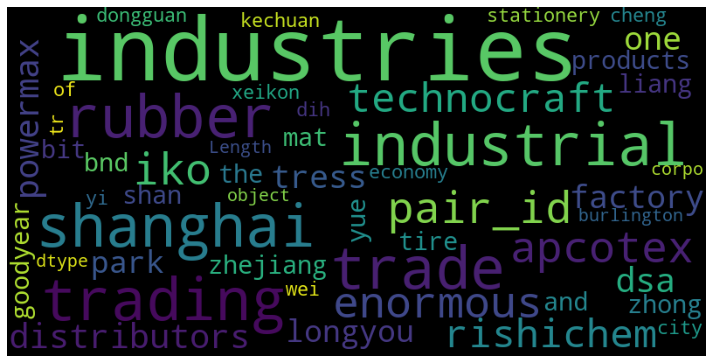

In [160]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = train['name_1'] + ' ' + train['name_2']
plot_wordcloud(text)

In [196]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
trans = vector.fit_transform(train.name_1+' '+train.name_2)

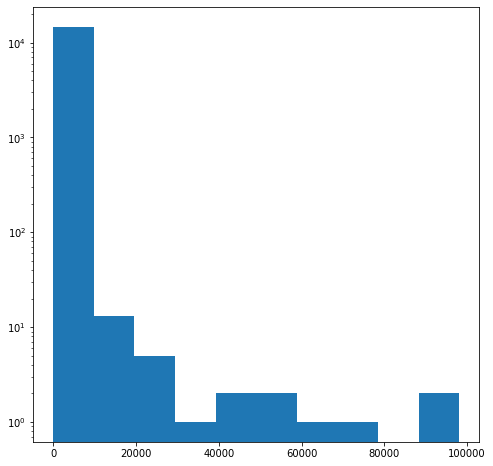

In [197]:
import matplotlib.pyplot as plt
counts = np.array(trans.sum(0))[0]
plt.figure(figsize=(8,8))
plt.hist(np.array(trans.sum(0))[0], log=True);

In [198]:
names = np.array(vector.get_feature_names())
# thresh = np.quantile(counts, 0.98)
STOPWORDS = set(names[counts > 8000])

In [199]:
train[['name_1', 'name_2']] = train[['name_1', 'name_2']].progress_applymap(lambda x: del_stopwords(x, STOPWORDS))
test[['name_1', 'name_2']] = test[['name_1', 'name_2']].progress_applymap(lambda x:  del_stopwords(x, STOPWORDS))

In [200]:
# избавиться от двойных пробелов и табуляций
train[['name_1', 'name_2']] = train[['name_1', 'name_2']].progress_applymap(lambda x: ' '.join(x.split()))
test[['name_1', 'name_2']] = test[['name_1', 'name_2']].progress_applymap(lambda x: ' '.join(x.split()))

### Извлечение признаков

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_relations(col, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.histplot(train.loc[train['is_duplicate'].eq(0), col], color='red', label='Не дубликаты', bins=20)
    sns.histplot(train.loc[train['is_duplicate'].eq(1), col], label='Дубликаты', bins=20)
    plt.legend();

def plot_count(col, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.countplot(col, hue='is_duplicate', data=train, log=True)

def calc_prob(col):
    print('вероятность дубликата при', col, '== True:' , train.loc[train[col]==1, 'is_duplicate'].mean())
    print('вероятность недубликата при', col, '== True:' , train.loc[train[col]==0, 'is_duplicate'].mean())

In [202]:
def first_n(a, b):
    if len(a) == 0 or len(b) == 0:
      return 0
    for idx in range(min(len(a), len(b))):
        if a[idx] != b[idx]:
            return idx
    return idx+1

In [169]:
def last_n(a, b):
    return first_n(a[::-1], b[::-1])

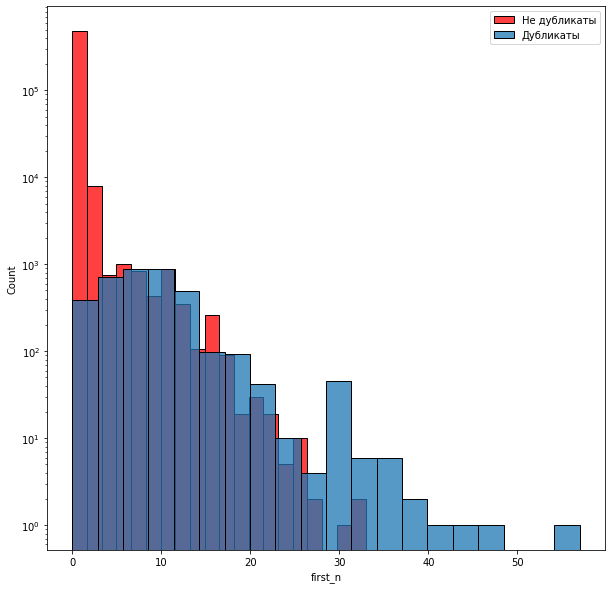

In [203]:
train['first_n'] = train.progress_apply(lambda x: first_n(x.name_1, x.name_2), axis=1)
test['first_n'] = test.progress_apply(lambda x: first_n(x.name_1, x.name_2), axis=1)

# train['last_n'] = train.progress_apply(lambda x: last_n(x.name_1, x.name_2), axis=1)
plot_relations('first_n')

In [204]:
def word_ol(name_1, name_2):
    a = set(name_1.split())
    b = set(name_2.split())
    return len(a & b)

In [205]:
def word_uni(name_1, name_2):
    a = set(name_1.split())
    b = set(name_2.split())
    return len(a | b)

In [206]:
def word_jakar(x: pd.Series):
  inter = word_ol(x.name_1, x.name_2)
  union = word_uni(x.name_1, x.name_2)
  return inter / (union + 1e-8)

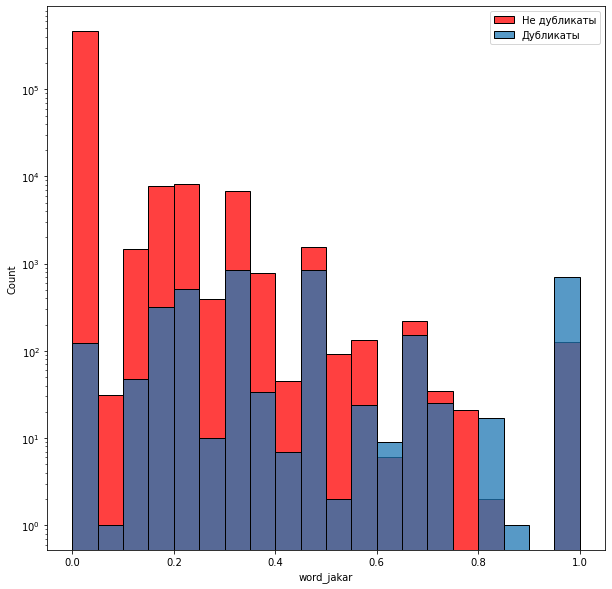

In [207]:
train['word_jakar'] = train.progress_apply(word_jakar, axis=1)
test['word_jakar'] = test.progress_apply(word_jakar, axis=1)
# train['word_ol'] = train.progress_apply(lambda x: word_ol(x.name_1, x.name_2), axis=1)
# train['word_uni'] = train.progress_apply(lambda x: word_uni(x.name_1, x.name_2), axis=1)
plot_relations('word_jakar')

In [208]:
def is_subset(x: pd.Series):
    if x.name_1 == '' or x.name_2 == '':
        return False
    a = set(x.name_1.split())
    b = set(x.name_2.split())
    return a.issubset(b) or b.issubset(a)

In [209]:
train['is_subset'] = train.progress_apply(is_subset, axis=1)
test['is_subset'] = test.progress_apply(is_subset, axis=1)
calc_prob('is_subset')


вероятность дубликата при is_subset == True: 0.48472634705133644
вероятность недубликата при is_subset == True: 0.0027843968323176607


In [421]:
!pip install strsimpy
from strsimpy.levenshtein import Levenshtein
leven = Levenshtein()

     |████████████████████████████████| 51kB 2.6MB/s 


In [422]:
'''
Недостаток: одно слово из name_1 может быть близким сразу к двум из name_2. Главный недостаток: метод хуйня
'''
def my_metric(x: pd.Series):
    a = x.name_1.split()
    b = x.name_2.split()
    # длина a должна быть меньше b
    if len(a) > len(b):
      a, b = b, a
    
    res = sum([min([leven.distance(i, j) for j in b]) for i in a])
    return res

train['my_metric'] = train.progress_apply(my_metric, axis=1)
test['my_metric'] = test.progress_apply(my_metric, axis=1)

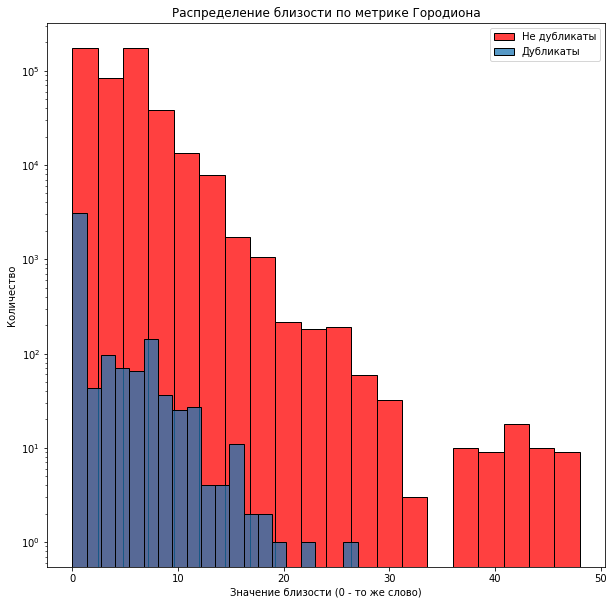

In [423]:
plot_relations('my_metric', 'Распределение близости по метрике Городиона', 'Значение близости (0 - то же слово)', 'Количество')

In [210]:
# разница в количестве слов и количестве символов
# train['word_diff'] = train.progress_apply(lambda x: abs(len(x.name_1.split()) - len(x.name_2.split())), axis=1)
# train['len_diff'] = train.progress_apply(lambda x: abs(len(x.name_1) - len(x.name_2)), axis=1)

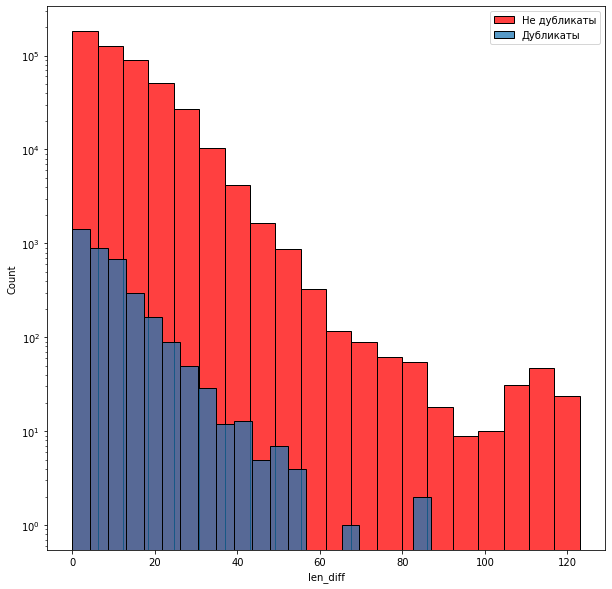

In [77]:
plot_relations('len_diff')

In [71]:
def is_substr(x: pd.Series):
    if x.name_1 == '' or x.name_2 == '':
        return False
    a = sorted(set(x.name_1.split()))
    b = sorted(set(x.name_2.split()))
    a = ''.join(a)
    b = ''.join(b)
    return a in b or b in a

# train['is_substr'] = train.progress_apply(is_substr, axis=1)
# test['is_substr'] = test.progress_apply(is_substr, axis=1)
# calc_prob('is_substr')


вероятность дубликата при is_substr == True: 0.28468680528311757
вероятность недубликата при is_substr == True: 0.0030213884105987285


In [211]:
# количество символов и количество букв
train['nchar_1'] = train['name_1'].progress_apply(len)
train['nchar_2'] = train['name_2'].progress_apply(len)
# train['nword_1'] = train.name_1.str.split().apply(len)
# train['nword_2'] = train.name_2.str.split().apply(len)

test['nchar_1'] = test['name_1'].progress_apply(len)
test['nchar_2'] = test['name_2'].progress_apply(len)

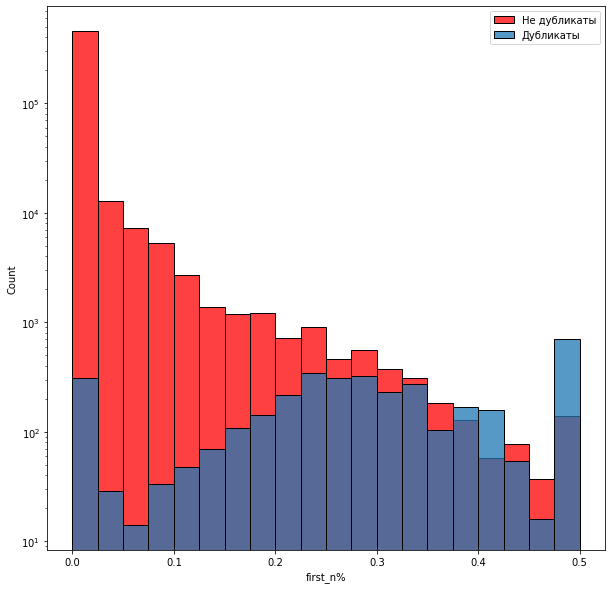

In [212]:
train['first_n%'] = train['first_n'] / (train['nchar_1'] + train['nchar_2'] + 1e-8)
test['first_n%'] = test['first_n'] / (test['nchar_1'] + test['nchar_2'] + 1e-8)

plot_relations('first_n%')

In [181]:
# вычисление косинусного расстояния между словами
# from sklearn.feature_extraction.text import TfidfVectorizer
# from scipy.sparse.linalg import norm
# vect = TfidfVectorizer()
# vect.fit(train.name_1 + ' ' + train.name_2)
# name_1 = vect.transform(train.name_1)
# name_2 = vect.transform(train.name_2)
# cosine = np.array(name_1.multiply(name_2).sum(1)).ravel() / (norm(name_1, axis=1) * norm(name_2, axis=1) + 1e-8)
# train['cosine'] = cosine

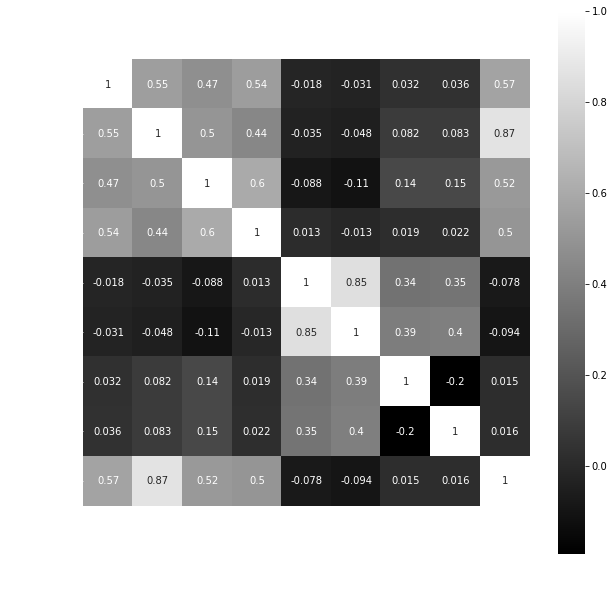

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
_, ax = plt.subplots(figsize=(10,10))
ax.tick_params(colors='white', labelsize=14)
sns.heatmap(train.corr(), annot=True, cmap='gray', square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45);

### Обучение модели

In [213]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score

nb=  BernoulliNB()
xgb = XGBClassifier(n_jobs=-1, random_state=0)
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
log = LogisticRegression()
cv = StratifiedKFold(5, shuffle=True, random_state=0)

In [219]:
X, y = train[['first_n%', 'word_jakar', 'is_subset', 'len_diff']], train['is_duplicate']

In [221]:
cross_val_score(xgb, X, y, cv=5, scoring='f1')

array([0.64828614, 0.67577283, 0.63629574, 0.65491924, 0.63432836])

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [223]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [224]:
print(classification_report(y_train, log.predict_proba(X_train)[:, 1] > 0.21))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395335
           1       0.63      0.61      0.62      2920

    accuracy                           0.99    398255
   macro avg       0.81      0.81      0.81    398255
weighted avg       0.99      0.99      0.99    398255



In [39]:
print(classification_report(y_val, log.predict_proba(X_val)[:, 1] > 0.21))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98826
           1       0.61      0.62      0.62       738

    accuracy                           0.99     99564
   macro avg       0.80      0.81      0.81     99564
weighted avg       0.99      0.99      0.99     99564



,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0


In [ ]:
df.loc[y_val.index, ['name_1', 'name_2']][(y_val != pred) & (y_val == 1)].merge(train[['name_1', 'name_2', 'is_subset', 'first_n%', 'word_jakar']], left_index=True, right_index=True).to_excel('error.xlsx')

In [ ]:
params = {
    'alpha': np.logspace(-6, 5, 12)
}
grid = GridSearchCV(ridge, param_grid=params, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight='balanced',
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{'alpha': 1000.0}

In [ ]:
np.mean([0.55439056, 0.5444408 ])

0.54941568

In [ ]:
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [47]:
preds = log.predict_proba(test[['first_n%', 'word_jakar', 'is_subset']])[:, 1] > 0.21

In [48]:
df = pd.read_csv('drive/MyDrive/Sibur/sample_submission.csv', index_col='pair_id')

In [49]:
df.is_duplicate = preds.astype(int)

In [50]:
df.is_duplicate.value_counts()

0    211915
1      1334
Name: is_duplicate, dtype: int64

In [52]:
df.to_csv('stopwords_log_sub.csv')

In [ ]:
is_subset(pd.Series(dict(name_1='Газпром', name_2='Шанхай газпром')))

False

### Метрики

In [ ]:
!pip install strsimpy
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.optimal_string_alignment import OptimalStringAlignment
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
from strsimpy.metric_lcs import MetricLCS
# from strsimpy.cosine import Сosine

levenshtein = Levenshtein()
optima = OptimalStringAlignment()
jaro = JaroWinkler()
LCS = LongestCommonSubsequence()
mLCS = MetricLCS()

# train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
# test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
# train["optima"] = train.progress_apply(lambda r: optima.distance(r.name_1, r.name_2), axis=1)
# test["optima"] = test.progress_apply(lambda r: optima.distance(r.name_1, r.name_2), axis=1)
train["jaro"] = train.progress_apply(lambda r: jaro.distance(r.name_1, r.name_2), axis=1)
# test["jaro"] = test.progress_apply(lambda r: jaro.distance(r.name_1, r.name_2), axis=1)
# train["LCS"] = train.progress_apply(lambda r: LCS.distance(r.name_1, r.name_2), axis=1)
# test["LCS"] = test.progress_apply(lambda r: LCS.distance(r.name_1, r.name_2), axis=1)
# train["mLCS"] = train.progress_apply(lambda r: mLCS.distance(r.name_1, r.name_2), axis=1)
# test["mLCS"] = test.progress_apply(lambda r: mLCS.distance(r.name_1, r.name_2), axis=1)
# train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2), axis=1)
# test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2), axis=1)

     |████████████████████████████████| 51kB 4.8MB/s 


In [ ]:
from nltk import edit_distance

In [ ]:
from unidecode import unidecode
import re
def preprocess(text):
    text = text.lower()
    text = text.replace('-', ' ')
    text = unidecode(text)
    text = re.sub(r'[^a-z0-9]', ' ', text)
    return text

In [ ]:
def get_dist(name_1, name_2):
    name_1 = preprocess(name_1)
    name_2 = preprocess(name_2)
    return edit_distance(name_1, name_2) / max(len(name_1), len(name_2))

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from itertools import chain

In [ ]:
df_dup = df[df.is_duplicate == 1]

In [ ]:
df_norm = df[df.is_duplicate == 0]

In [ ]:
spam = []
for idx, ser in tqdm(df_dup.iterrows(), total=df_dup.shape[0]):
    spam.append(get_dist(ser.name_1, ser.name_2))

In [ ]:
df_dup['dist'] = spam

<ipython-input-229-fe46ed779cb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dup['dist'] = spam


In [ ]:
norm = []
for idx, ser in tqdm(df_norm.iterrows(), total=df_norm.shape[0]):
    norm.append(get_dist(ser.name_1, ser.name_2))

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

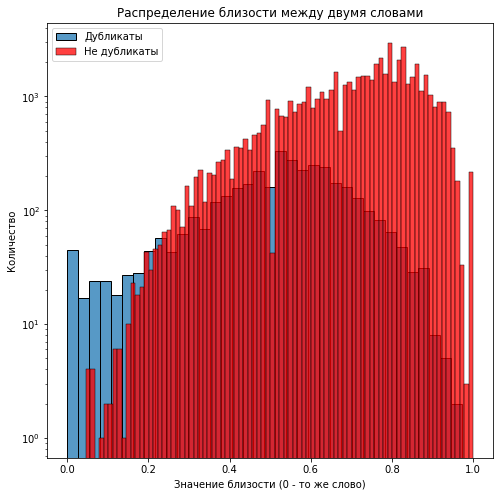

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Распределение близости между двумя словами')
plt.yscale('log')
plt.xlabel('Значение близости (0 - то же слово)')
plt.ylabel('Количество')
sns.histplot(spam, label='Дубликаты')
sns.histplot(norm, color='red', label='Не дубликаты')
plt.legend();

In [ ]:
data = pd.concat([df_dup, df_norm])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df1[['dist']], df1['is_duplicate'], test_size=0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression

### Жакар с n граммами

In [ ]:
def get_ngram(text, ngram=3, stride=1) -> set:
    a = set()
    for i in range(0, len(text), stride):
        spam = text[i:i+ngram].strip()
        if spam and len(spam) == ngram:
            a.add(spam)
    return a

get_ngram('ababcdab', 2, 1)

{'ab', 'ba', 'bc', 'cd', 'da'}

In [ ]:
def jakar_ngram(x: pd.Series, ngram=3, stride=1):
    name_1 = ''.join(x.name_1.split())
    name_2 = ''.join(x.name_2.split())
    ngram_1 = get_ngram(name_1, ngram, stride)
    ngram_2 = get_ngram(name_2, ngram, stride)
    return len(ngram_1 & ngram_2) / (len(ngram_1 | ngram_2) + 1e-8)

In [ ]:
train['jakar_3gram'] = train[['name_1', 'name_2']].progress_apply(lambda x: jakar_ngram(x, 3), axis=1)

In [ ]:
spam = df[df.is_duplicate == 1][:10][['name_1', 'name_2']].applymap(trans_text).apply(trans, axis=1)

NameError: ignored

In [ ]:
from sklearn.metrics import jaccard_score